In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import simulate as sim
import kalman as kf

from scipy.stats import norm
from matplotlib import cm
from importlib import reload
from scipy.optimize import fmin, minimize

# Simulating Data

In [18]:
# S0 = 149.54
S0 = 100
T = 30
# r = 0.0245
r = 0.2
q = 0
N = 1000

In [19]:
true_params = [r, 2.2, 0.01, 0.3, 0.6, 0.02]

In [20]:
y = sim.simulate_heston_state(true_params, S0, N=N) 

### simulate path and ekf generated path

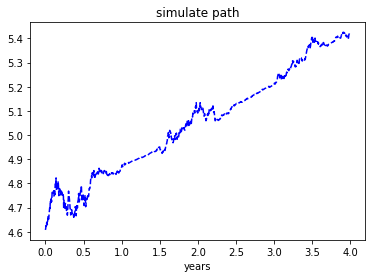

In [21]:
years = np.arange(y.shape[-1]-1) * (1/250)
plt.plot(years, y[0,1:].T, 'b--')
plt.title('simulate path')
plt.xlabel('years')
plt.show()

# neg vol: [[59]]


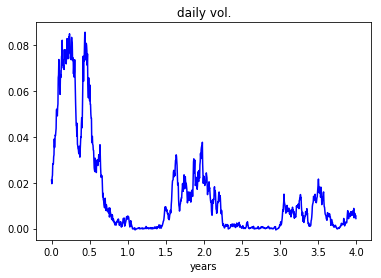

In [22]:
print("# neg vol:", sum(y[1,1:].T<0))
plt.plot(years, y[1,1:].T, 'b-')
plt.title('daily vol.')
plt.xlabel('years')
plt.show()

# Optimization

In [23]:
def wrap_heston_obj(params, *args):
    y = args[0]
    S0 = args[1]
    return kf.ukf_heston_obj(y, params, S0)

In [24]:
num_iter = 1
def callbackF(xi):
    global num_iter
    global arg
    print('i: ' + str(num_iter))
    print('x_i: ' + str(xi))
    print('f_i: ' + str(wrap_heston_obj(xi, *args)))
    num_iter += 1

In [25]:
args = (np.array(y[0,:])[0], S0)

# Param Select

In [26]:
def param_select(params1, params2, n_alphas=1000):
    params1 = np.array(params1)
    params2 = np.array(params2)
    alphas = np.linspace(0, 1, n_alphas)
    params = [a*params1+(1-a)*params2 for a in alphas]
    objs = [wrap_heston_obj(p, *args) for p in params]
    return objs

In [27]:
init_params = [0.5, 0.8, 0.08, 0.4, -0.3, 0.23]
params2 = [0.2, 3.4, 0.05, 0.1, -0.05, 0.1]

In [28]:
print("Init params: {}".format(init_params))
print("True Params: {}".format(true_params))

Init params: [0.5, 0.8, 0.08, 0.4, -0.3, 0.23]
True Params: [0.2, 2.2, 0.01, 0.3, 0.6, 0.02]


In [29]:
# maxiter = 10000
# xopt, fopt, _, _, _ = fmin(wrap_heston_obj, xopt, args=args, maxiter=maxiter, callback=callbackF, 
#                            disp=True, retall=False, full_output=True)

# Plot Results

In [30]:
x_preds, y_preds = kf.ukf_heston_obj(args[0], true_params, args[1], return_vals=True)

[0.2, 2.2, 0.01, 0.3, 0.6, 0.02]


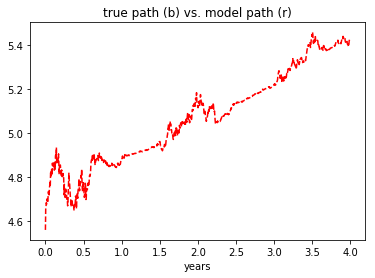

In [31]:
years = np.arange(y.shape[-1]-1) * (1/250)
# plt.plot(years, y[0,1:].T, 'b--')
plt.plot(years, y_preds[1:], 'r--')
plt.title('true path (b) vs. model path (r)')
plt.xlabel('years')
plt.show()

# neg vol: [[59]]


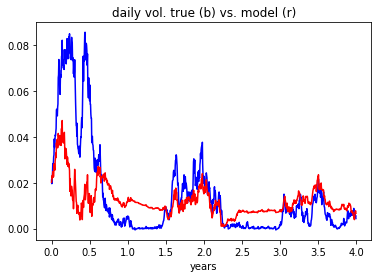

In [32]:
print("# neg vol:", sum(y[1,1:].T<0))
plt.plot(years[:], np.array(y[1,1:])[0], 'b-')
plt.plot(years[:], x_preds[1:], 'r-')
plt.title('daily vol. true (b) vs. model (r)')
plt.xlabel('years')
plt.show()